# **PREDICT STOCK MARKET BY USING LSTM**

In [ ]:
# !pip install pandas_datareader
# !pip install plotly
# !pip install yfinance

In [ ]:
from pandas_datareader import data 
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import pandas_datareader.data as web
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score

In [ ]:
def convert_date_format(date_str):
    date_obj = datetime.strptime(date_str, '%d/%m/%Y')
    new_date_str = date_obj.strftime('%Y-%m-%d')
    return new_date_str

def convert_date_format_US(date_str):
    date_obj = datetime.strptime(date_str, '%m/%d/%Y')
    new_date_str = date_obj.strftime('%Y-%m-%d')
    return new_date_str

In [ ]:
df_raw1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VNINDEX1.csv')
df_raw2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VNINDEX2.csv')

frame_raw = [df_raw1, df_raw2]

df_raw = pd.concat(frame_raw)

print(df_raw)

           Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
0    25/03/2021  1,163.10  1,164.41  1,170.76  1,154.44  690.73K      0.11%
1    24/03/2021  1,161.81  1,169.42  1,174.20  1,154.22  750.48K     -1.83%
2    23/03/2021  1,183.45  1,190.28  1,191.47  1,177.10  683.72K     -0.92%
3    22/03/2021  1,194.43  1,200.05  1,200.21  1,189.31  700.87K      0.03%
4    19/03/2021  1,194.05  1,195.47  1,199.67  1,191.96  680.90K     -0.57%
..          ...       ...       ...       ...       ...      ...        ...
192  31/03/2021  1,191.44  1,186.36  1,196.45  1,186.36  703.08K      0.43%
193  30/03/2021  1,186.36  1,179.64  1,187.29  1,172.85  780.73K      0.91%
194  29/03/2021  1,175.68  1,169.65  1,175.77  1,165.78  660.95K      1.16%
195  26/03/2021  1,162.21  1,162.71  1,165.76  1,137.90  670.46K     -0.08%
196  25/03/2021  1,163.10  1,164.41  1,170.76  1,154.44  690.73K      0.11%

[5445 rows x 7 columns]


In [ ]:
df_raw.isna().sum()

Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
KL            7
% Thay đổi    0
dtype: int64

In [ ]:
df_raw = (df_raw.drop_duplicates())

df_raw = df_raw.dropna()

df_raw = df_raw.drop(['% Thay đổi'], axis = 1)

df_raw = (df_raw.rename(columns = {'Ngày':'Date','Lần cuối':'Close','Mở':'Open','Cao':'High','Thấp':'Low','KL':'Volumn'}))

df_raw['Date'] = df_raw['Date'].apply(convert_date_format)
df_raw["Date"] = pd.to_datetime(df_raw["Date"])

df_raw = (df_raw.replace(',','',regex=True))


# extract the numeric value and the suffix
numeric_value = df_raw['Volumn'].str.extract('(\d+\.?\d*)', expand=False).astype(float)
suffix = df_raw['Volumn'].str.extract('([KM])', expand=False)

# multiply the numeric value by the corresponding factor based on the suffix
df_raw['Volumn'] = numeric_value * suffix.map({'K': 1000, 'M': 1000000}).fillna(1)
df_raw['Volumn'] = df_raw['Volumn'].astype(int)
df_raw['Open'] = df_raw['Open'].astype(float)
df_raw['Close'] = df_raw['Close'].astype(float)
df_raw['High'] = df_raw['High'].astype(float)
df_raw['Low'] = df_raw['Low'].astype(float)

df = df_raw.sort_values(by=['Date'], ascending=True)
df = df.set_index("Date") 
# print(df.dtypes)
print(df)

              Close     Open     High      Low  Volumn
Date                                                  
2000-07-31   101.55   101.55   101.55   101.55      10
2000-08-04   105.20   105.20   105.20   105.20       0
2000-08-07   106.92   106.92   106.92   106.92      10
2000-08-09   108.64   108.64   108.64   108.64      20
2000-08-11   110.36   110.36   110.36   110.36      10
...             ...      ...      ...      ...     ...
2022-12-26   985.21  1020.34  1021.89   985.21  623490
2022-12-27  1004.57   985.21  1007.88   983.67  593360
2022-12-28  1015.66  1004.57  1020.52   998.97  590450
2022-12-29  1009.29  1015.66  1021.96  1009.29  462660
2022-12-30  1007.09  1009.29  1017.99  1007.09  407140

[5437 rows x 5 columns]


In [ ]:
stock_open = np.array(df['Open']) # stock_open is numpy array of transpose of df['Open']
stock_close = np.array(df['Close']) # stock_close is numpy array of transpose of df['Close']

In [ ]:
#‘movement’ is the difference of opening and closing prices of a particular day. Positive movement suggests to go long on stock(buy) and negative movement suggests to short the stock(sell).
movements = stock_close - stock_open

In [ ]:
sum_of_movement = stock_close - stock_open

In [ ]:
# plt.figure(figsize = (30,12)) 

# plt.title('Close',fontsize = 20)
# plt.xticks(fontsize = 5,rotation=90)
# plt.yticks(fontsize = 20)
# plt.xlabel('Date',fontsize = 15)
# plt.ylabel('Closing price',fontsize = 15)
# ax = plt.plot(df['Date'], df['Close'])

In [ ]:
training_set = df.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
X_train = []
# 'y_train' Output with next day's stock price
y_train = []
for i in range(60, 5437):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
display(df)

,Close,Open,High,Low,Volumn
Date,,,,,
2000-07-31,101.55,101.55,101.55,101.55,10
2000-08-04,105.20,105.20,105.20,105.20,0
2000-08-07,106.92,106.92,106.92,106.92,10
2000-08-09,108.64,108.64,108.64,108.64,20
2000-08-11,110.36,110.36,110.36,110.36,10
...,...,...,...,...,...
2022-12-26,985.21,1020.34,1021.89,985.21,623490
2022-12-27,1004.57,985.21,1007.88,983.67,593360
2022-12-28,1015.66,1004.57,1020.52,998.97,590450


In [ ]:
X_train

array([[[0.        ],
        [0.0025479 ],
        [0.00374856],
        ...,
        [0.06008167],
        [0.06251789],
        [0.06512862]],

       [[0.0025479 ],
        [0.00374856],
        [0.00494922],
        ...,
        [0.06251789],
        [0.06512862],
        [0.06773237]],

       [[0.00374856],
        [0.00494922],
        [0.00614987],
        ...,
        [0.06512862],
        [0.06773237],
        [0.07034309]],

       ...,

       [[0.68171443],
        [0.69994765],
        [0.67918746],
        ...,
        [0.64295138],
        [0.64136679],
        [0.61684409]],

       [[0.69994765],
        [0.67918746],
        [0.65223552],
        ...,
        [0.64136679],
        [0.61684409],
        [0.63035845]],

       [[0.67918746],
        [0.65223552],
        [0.65682175],
        ...,
        [0.61684409],
        [0.63035845],
        [0.63809989]]])

In [ ]:
# Part 2 - Building the RNN
# Building a robust stacked LSTM with dropout regularization

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

regressor = Sequential()

regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

regressor.add(LSTM(units = 100, return_sequences = False))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
169/169 [==============================] - 13s 22ms/step - loss: 0.0048
Epoch 2/50
169/169 [==============================] - 3s 16ms/step - loss: 4.1610e-04
Epoch 3/50
169/169 [==============================] - 3s 18ms/step - loss: 3.4737e-04
Epoch 4/50
169/169 [==============================] - 3s 18ms/step - loss: 2.7818e-04
Epoch 5/50
169/169 [==============================] - 2s 14ms/step - loss: 3.2857e-04
Epoch 6/50
169/169 [==============================] - 3s 16ms/step - loss: 2.3248e-04
Epoch 7/50
169/169 [==============================] - 3s 15ms/step - loss: 2.0790e-04
Epoch 8/50
169/169 [==============================] - 3s 19ms/step - loss: 1.9780e-04
Epoch 9/50
169/169 [==============================] - 2s 13ms/step - loss: 1.8522e-04
Epoch 10/50
169/169 [==============================] - 2s 10ms/step - loss: 1.6906e-04
Epoch 11/50
169/169 [==============================] - 1s 8ms/step - loss: 1.4229e-04
Epoch 12/50
169/169 [==============================] - 1

In [ ]:
regressor.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_20 (LSTM)              (None, 100)               80400     
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dataset_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VNIndex_2023.csv')
dataset_test = (dataset_test.drop_duplicates())

dataset_test = dataset_test.dropna()

dataset_test = dataset_test.drop(['Change %'], axis = 1)

dataset_test = (dataset_test.rename(columns = {'Vol.':'Volumn','Price':'Close'}))

df1 = dataset_test.iloc[:63]
df1['Date'] = df1['Date'].apply(convert_date_format_US)

# split the rest of the elements into another DataFrame
df2 = dataset_test.iloc[63:]
df2['Date'] = df2['Date'].apply(convert_date_format)

dataset_test = pd.concat([df1,df2],axis = 0)
dataset_test["Date"] = pd.to_datetime(dataset_test["Date"])

dataset_test = (dataset_test.replace(',','',regex=True))


# extract the numeric value and the suffix
numeric_value = dataset_test['Volumn'].str.extract('(\d+\.?\d*)', expand=False).astype(float)
suffix = dataset_test['Volumn'].str.extract('([KM])', expand=False)

# multiply the numeric value by the corresponding factor based on the suffix
dataset_test['Volumn'] = numeric_value * suffix.map({'K': 1000, 'M': 1000000}).fillna(1)
dataset_test['Volumn'] = dataset_test['Volumn'].astype(int)
dataset_test['Open'] = dataset_test['Open'].astype(float)
dataset_test['Close'] = dataset_test['Close'].astype(float)
dataset_test['High'] = dataset_test['High'].astype(float)
dataset_test['Low'] = dataset_test['Low'].astype(float)

dataset_test = dataset_test.sort_values(by=['Date'], ascending=True)
dataset_test = dataset_test.set_index("Date") 
# print(df.dtypes)
print(dataset_test)

              Close     Open     High      Low  Volumn
Date                                                  
2023-01-03  1043.90  1007.09  1043.90  1007.09  551330
2023-01-04  1046.35  1043.90  1052.60  1041.56  647730
2023-01-05  1055.82  1048.17  1058.14  1046.64  535050
2023-01-06  1051.44  1055.82  1065.58  1047.26  698500
2023-01-09  1054.21  1058.28  1062.12  1050.95  475200
...             ...      ...      ...      ...     ...
2023-03-31  1064.64  1059.44  1067.55  1059.44  639930
2023-04-03  1079.28  1064.64  1079.28  1064.64  821310
2023-04-04  1078.45  1079.28  1082.21  1075.10  803890
2023-04-05  1080.86  1078.45  1080.86  1074.10  793750
2023-04-06  1070.91  1080.86  1084.52  1070.91  998760

[63 rows x 5 columns]


2/2 [==============================] - 1s 9ms/step


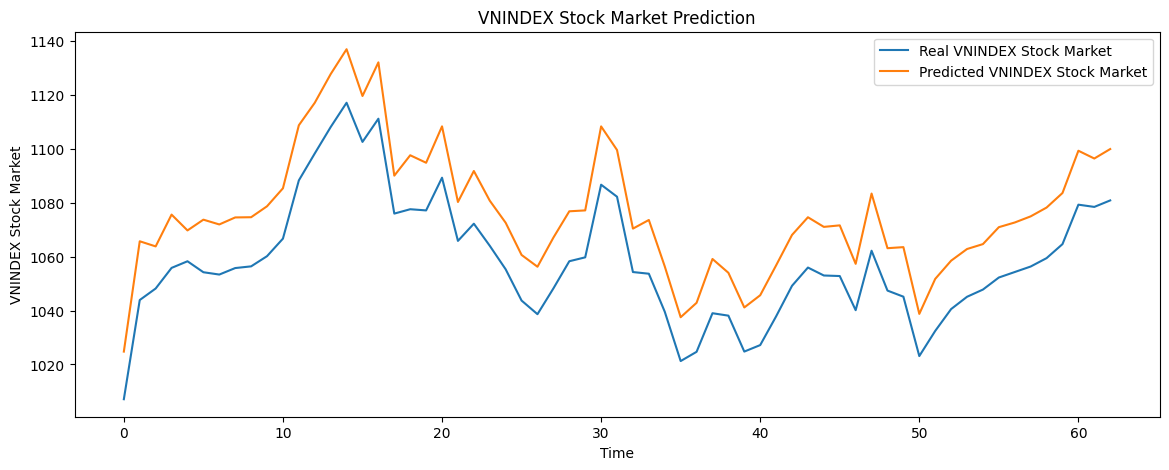

In [ ]:
# Evaluate on testing set
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2023

real_stock_price_LSTM = dataset_test.iloc[:, 1:2].values
# Getting the predicted stock price of 2023
# We need 60 previous inputs for each day of the Test_set in 2023 
# Combine 'dataset_train' and 'dataset_test'
# 'axis = 0' for Vertical Concatenation to add rows to the bottom
dataset_total_LSTM = pd.concat((df['Close'], dataset_test['Close']), axis = 0)
# Extract Stock Prices for Test time period, plus 60 days previous
inputs_LSTM = dataset_total_LSTM[len(dataset_total_LSTM) - len(dataset_test) - 60:].values
# 'reshape' function to get it into a NumPy format
inputs_LSTM = inputs_LSTM.reshape(-1,1)
# Inputs need to be scaled to match the model trained on Scaled Feature
inputs_LSTM = sc.transform(inputs_LSTM)
# The following is pasted from above and modified for Testing, romove all 'Ys'
X_test = []

for i in range(60, 123):
    X_test.append(inputs_LSTM[i-60:i, 0])

X_test = np.array(X_test)
# We need a 3D input so add another dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Predict the Stock Price
predicted_stock_price_LSTM = regressor.predict(X_test)
# We need to inverse the scaling of our prediction to get a Dollar amount
predicted_stock_price_LSTM = sc.inverse_transform(predicted_stock_price_LSTM)

# Visualising the results
plt.figure(figsize=(14,5))
plt.style.context('fivethirtyeight')
plt.plot(real_stock_price_LSTM, label = 'Real VNINDEX Stock Market')
plt.plot(predicted_stock_price_LSTM, label = 'Predicted VNINDEX Stock Market')
plt.title('VNINDEX Stock Market Prediction')
plt.xlabel('Time')
plt.ylabel('VNINDEX Stock Market')
plt.legend()
plt.show()

In [ ]:
print('MAE: ',mean_absolute_error(real_stock_price_LSTM,predicted_stock_price_LSTM))
print('MSE: ',mean_squared_error(real_stock_price_LSTM,predicted_stock_price_LSTM))
print('RMSE: ',np.sqrt(mean_squared_error(real_stock_price_LSTM,predicted_stock_price_LSTM)))
print('Variance Regression Score: ',explained_variance_score(real_stock_price_LSTM,predicted_stock_price_LSTM))

MAE:  18.16566762772817
MSE:  333.2266718152953
RMSE:  18.254497303823385
Variance Regression Score:  0.9935409958948762


In [ ]:
# plt.scatter(real_stock_price,predicted_stock_price)
# plt.show()

In [ ]:
# df_predict = pd.DataFrame(predicted_stock_price, columns=['Prediction'])
# df_real = pd.DataFrame(real_stock_price, columns=['Real'])
# result = pd.concat([df_real, df_predict], axis=1)
# print(result)

In [ ]:
# df_lstm = pd.concat([df,dataset_test], axis = 0)
# df_lstm = df_lstm.drop(['Volumn'], axis = 1)
# plt.figure(figsize=(20,5))
# sns.lineplot(data =df_lstm,)

In [ ]:
# print(df_lstm)

In [ ]:
from keras.layers import GRU

model = Sequential()

model.add(GRU(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(GRU(units = 100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
169/169 [==============================] - 8s 12ms/step - loss: 0.0044
Epoch 2/50
169/169 [==============================] - 1s 8ms/step - loss: 9.5893e-04
Epoch 3/50
169/169 [==============================] - 1s 8ms/step - loss: 8.5456e-04
Epoch 4/50
169/169 [==============================] - 1s 8ms/step - loss: 8.0126e-04
Epoch 5/50
169/169 [==============================] - 2s 9ms/step - loss: 7.5001e-04
Epoch 6/50
169/169 [==============================] - 2s 13ms/step - loss: 7.1410e-04
Epoch 7/50
169/169 [==============================] - 1s 7ms/step - loss: 7.7266e-04
Epoch 8/50
169/169 [==============================] - 2s 10ms/step - loss: 6.2158e-04
Epoch 9/50
169/169 [==============================] - 2s 11ms/step - loss: 6.9687e-04
Epoch 10/50
169/169 [==============================] - 2s 10ms/step - loss: 6.1284e-04
Epoch 11/50
169/169 [==============================] - 1s 8ms/step - loss: 5.7918e-04
Epoch 12/50
169/169 [==============================] - 1s 8ms/

In [ ]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_13 (GRU)                (None, 60, 100)           30900     
                                                                 
 dropout_18 (Dropout)        (None, 60, 100)           0         
                                                                 
 gru_14 (GRU)                (None, 100)               60600     
                                                                 
 dropout_19 (Dropout)        (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                                 
Total params: 91,601
Trainable params: 91,601
Non-trainable params: 0
_________________________________________________________________


2/2 [==============================] - 1s 8ms/step


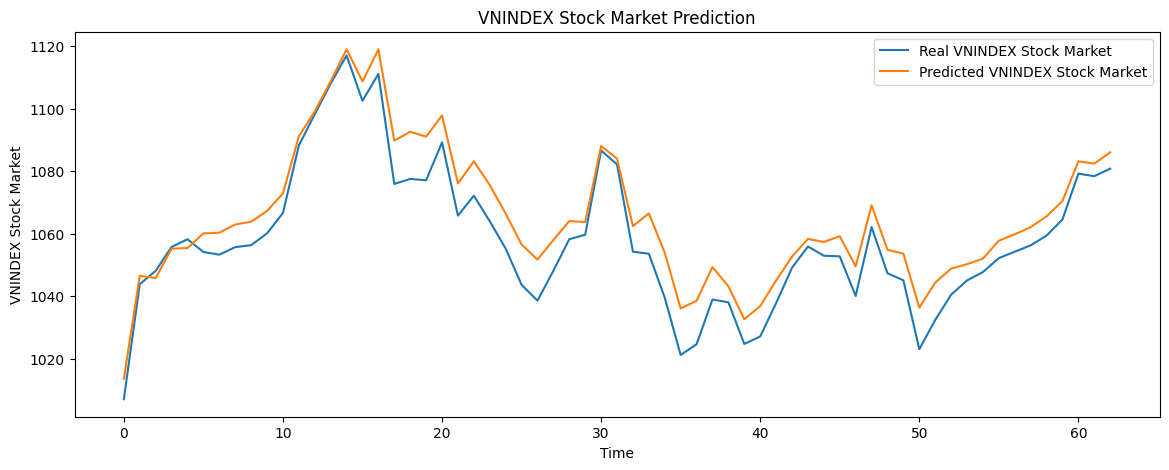

In [ ]:
real_stock_price_gru = dataset_test.iloc[:, 1:2].values

dataset_total_gru = pd.concat((df['Close'], dataset_test['Close']), axis = 0)
inputs_gru = dataset_total_gru[len(dataset_total_gru) - len(dataset_test) - 60:].values

inputs_gru = inputs_gru.reshape(-1,1)

inputs_gru = sc.transform(inputs_gru)

X_test = []

for i in range(60, 123):
    X_test.append(inputs_gru[i-60:i, 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price_gru = model.predict(X_test)

predicted_stock_price_gru = sc.inverse_transform(predicted_stock_price_gru)

plt.figure(figsize=(14,5))
plt.style.context('fivethirtyeight')
plt.plot(real_stock_price_gru, label = 'Real VNINDEX Stock Market')
plt.plot(predicted_stock_price_gru, label = 'Predicted VNINDEX Stock Market')
plt.title('VNINDEX Stock Market Prediction')
plt.xlabel('Time')
plt.ylabel('VNINDEX Stock Market')
plt.legend()
plt.show()

In [ ]:
print('MAE: ',mean_absolute_error(real_stock_price_gru,predicted_stock_price_gru))
print('MSE: ',mean_squared_error(real_stock_price_gru,predicted_stock_price_gru))
print('RMSE: ',np.sqrt(mean_squared_error(real_stock_price_gru,predicted_stock_price_gru)))
print('Variance Regression Score: ',explained_variance_score(real_stock_price_gru,predicted_stock_price_gru))

MAE:  7.3121106925843184
MSE:  68.88249452765803
RMSE:  8.299547850796333
Variance Regression Score:  0.9640244129645003


In [ ]:
from keras.layers import GRU

combine = Sequential()

combine.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
combine.add(Dropout(0.2))

combine.add(GRU(units = 100, return_sequences = False))
combine.add(Dropout(0.2))

combine.add(Dense(units = 1))

combine.compile(optimizer = 'adam', loss = 'mean_squared_error')

combine.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
169/169 [==============================] - 6s 8ms/step - loss: 0.0046
Epoch 2/50
169/169 [==============================] - 1s 8ms/step - loss: 0.0011
Epoch 3/50
169/169 [==============================] - 1s 8ms/step - loss: 0.0010
Epoch 4/50
169/169 [==============================] - 1s 8ms/step - loss: 9.0601e-04
Epoch 5/50
169/169 [==============================] - 1s 8ms/step - loss: 9.2823e-04
Epoch 6/50
169/169 [==============================] - 1s 8ms/step - loss: 7.6477e-04
Epoch 7/50
169/169 [==============================] - 1s 8ms/step - loss: 8.2436e-04
Epoch 8/50
169/169 [==============================] - 2s 10ms/step - loss: 8.2643e-04
Epoch 9/50
169/169 [==============================] - 2s 11ms/step - loss: 7.9536e-04
Epoch 10/50
169/169 [==============================] - 2s 9ms/step - loss: 6.3422e-04
Epoch 11/50
169/169 [==============================] - 1s 8ms/step - loss: 6.1874e-04
Epoch 12/50
169/169 [==============================] - 1s 8ms/step - loss

2/2 [==============================] - 1s 11ms/step


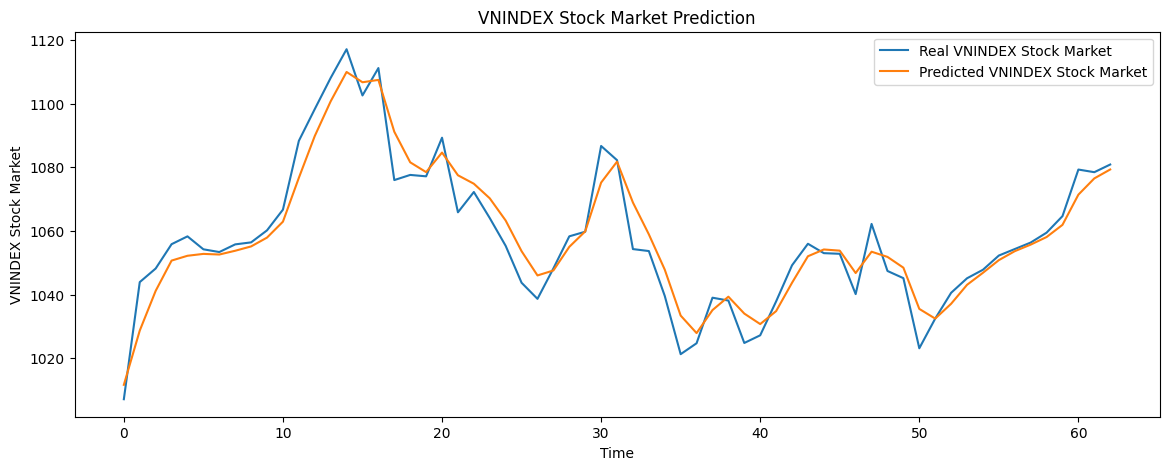

In [ ]:
real_stock_price_combine = dataset_test.iloc[:, 1:2].values

dataset_total_combine = pd.concat((df['Close'], dataset_test['Close']), axis = 0)
inputs_combine = dataset_total_combine[len(dataset_total_combine) - len(dataset_test) - 60:].values

inputs_combine = inputs_combine.reshape(-1,1)

inputs_combine = sc.transform(inputs_combine)

X_test = []

for i in range(60, 123):
    X_test.append(inputs_combine[i-60:i, 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price_combine = combine.predict(X_test)

predicted_stock_price_combine = sc.inverse_transform(predicted_stock_price_combine)

plt.figure(figsize=(14,5))
plt.style.context('fivethirtyeight')
plt.plot(real_stock_price_combine, label = 'Real VNINDEX Stock Market')
plt.plot(predicted_stock_price_combine, label = 'Predicted VNINDEX Stock Market')
plt.title('VNINDEX Stock Market Prediction')
plt.xlabel('Time')
plt.ylabel('VNINDEX Stock Market')
plt.legend()
plt.show()

In [ ]:
print('MAE: ',mean_absolute_error(real_stock_price_combine,predicted_stock_price_combine))
print('MSE: ',mean_squared_error(real_stock_price_combine,predicted_stock_price_combine))
print('RMSE: ',np.sqrt(mean_squared_error(real_stock_price_combine,predicted_stock_price_combine)))
print('Variance Regression Score: ',explained_variance_score(real_stock_price_combine,predicted_stock_price_combine))

MAE:  5.001432562934024
MSE:  41.079445830735786
RMSE:  6.40932491224589
Variance Regression Score:  0.918013375929722
